# Aprentação dos resultados

## Bibliotecas utilizadas

In [58]:
# OS
import sys

import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # não esqueça este
import matplotlib.pyplot as plt
%matplotlib inline

# Print
from pprint import pprint

# Timer
import timeit
from timeit import default_timer as timer

# Pickle
import pickle

#Cores
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

# Nuvem de palavras
from wordcloud import WordCloud

# tdm pode ser usado como medidor de prograsso para iteráveis
from tqdm import tqdm

%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [59]:
# Composição de uma paleta com 16 cores para visualização
# feita uma geracao  via https://color.hailpixel.com/ 
# e https://coolors.co/gradient-palette, etc.

categorias16 = [
        '#0000aa',
        '#ff9f00',
        '#BD63A2',
        '#AA7D50',
        '#ff006e',
        '#2ca02c',
        '#2E51E1',
        '#93bC15',
        '#d62728',
        '#D57F7D',
        '#f15bb5',
        '#8c564b',
        '#9467bd',
        '#f3722c',
        '#5f5f5f',
        '#969696'
        ]


## Carrega dados do pipeline

In [60]:
# Carrega corpora dictionary para o vocabulário
path = 'data/save/'
dict_name = 'rsc_dictionary'
dictfile = path + dict_name + '.dict'
id2word = corpora.Dictionary.load(dictfile)

# Carrega data_words gerados

data_words_processed = pickle.load(open('data/save/data_words_processed.pickle', 'rb'))

# Carrega lista com nomes dos arquivos
datafiles = pickle.load(open('data/save/datafiles.pickle', 'rb'))

# Carrega lista com os textos dos artigos
data = pickle.load(open('data/save/data.pickle', 'rb'))

In [61]:
# Carregando modelo LDA Gensim e Mallet treinados do disco
model_path = datapath("C:\\Users\\rgosd\\Documents\\TCC\\peabirus\\data\\save\\models\\lda\lda_model_10t")
lda_model = gensim.models.ldamodel.LdaModel.load(model_path)

model_path = datapath("C:\\Users\\rgosd\\Documents\\TCC\\peabirus\\data\\save\\models\\ldamallet\\ldamallet_model_10t")
ldamallet_model = gensim.models.ldamodel.LdaModel.load(model_path)

In [62]:
# Reconstroi o Corpus
texts = data_words_processed
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [63]:
# Cria lista com as URLs de acesso aos documentos no formato de link clicável de planilha (Excel / Libre Office Calc)
document_urls = []
for file in datafiles:
    index = re.sub(r'rsc_processed.*_(\d+)\.txt', r'\1', file)
    url = '=HYPERLINK("http://www.redepeabirus.com.br/redes/form/post?topico_id=' + index + '")'
    document_urls.append(url)
#print(document_urls[0:5])
len(document_urls)


44245

In [64]:
# Cria lista com os ANOS dos documentos
document_anos = []
for file in datafiles:
    ano = re.sub(r'rsc_processed.*?_(\d+)_.*\.txt', r'\1', file)
    document_anos.append(ano)
#print(document_urls[0:5])

In [65]:
len(document_anos)

44245

## Apresenta tópicos inferidos no modelo

In [66]:
topics = lda_model.show_topics(num_topics=10, num_words=10, log=False, formatted=True)
pprint(topics)

[(0,
  '0.008*"plantas" + 0.008*"agua" + 0.007*"solo" + 0.007*"uso" + '
  '0.006*"cafeina" + 0.006*"frutos" + 0.006*"lavoura" + 0.005*"controle" + '
  '0.005*"produtividade" + 0.005*"pesquisa"'),
 (1,
  '0.012*"bebida" + 0.009*"produto" + 0.007*"empresa" + 0.007*"marca" + '
  '0.006*"graos" + 0.005*"mundo" + 0.005*"coffee" + 0.005*"casa" + '
  '0.005*"sabor" + 0.004*"cafeterias"'),
 (2,
  '0.018*"especiais" + 0.014*"concurso" + 0.007*"minas" + 0.007*"fazenda" + '
  '0.006*"evento" + 0.006*"mulheres" + 0.006*"categoria" + 0.006*"senar" + '
  '0.005*"especial" + 0.005*"associacao"'),
 (3,
  '0.056*"saca" + 0.027*"safra" + 0.023*"exportacao" + 0.013*"dolar" + '
  '0.012*"volume" + 0.011*"arabica" + 0.011*"periodo" + 0.011*"consumo" + '
  '0.011*"pais" + 0.011*"preco"'),
 (4,
  '0.015*"cnc" + 0.013*"governo" + 0.012*"nacional" + 0.011*"recursos" + '
  '0.009*"credito" + 0.009*"agricultura" + 0.009*"rural" + 0.008*"conselho" + '
  '0.008*"ministerio" + 0.007*"federal"'),
 (5,
  '0.052*"chuv

## Tópicos dominantes por documento

In [67]:
def format_topics_documents(ldamodel=lda_model, corpus=corpus, doc_years=document_anos, texts=data, fnames=datafiles, txt_urls=document_urls):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(tqdm(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Topico_dominante', 'Topico_perc_contrib', 'Palavras_chave']

    # Adiciona o texto original, o nome dos arquivos e as URL de acesso dos documentos
    years = pd.Series(doc_years)
    contents = pd.Series(texts)
    file_names = pd.Series(datafiles)
    urls = pd.Series(document_urls)
    doc_topics_df = pd.concat([doc_topics_df, years, contents, file_names, urls,], axis=1)
    return(doc_topics_df)

In [68]:
# Cria dataframe com tópicos dominantes por documento

# Para mostrar mais caracteres nas columas do pandas
pd.options.display.max_colwidth = 80

df_topic_docs_keywords = format_topics_documents(ldamodel=lda_model, corpus=corpus, texts=data, fnames=datafiles, txt_urls=document_urls)

100%|██████████| 44245/44245 [18:12<00:00, 40.51it/s] 


In [69]:
# Define nos nomes das colunas
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Id_documento', 'Topico_dominante', 'Topico_perc_contrib', 'Palavras_chave', 'Ano', 'Texto', 'Nome_arquivo', 'Link_doc']

In [70]:
df_dominant_topic

,Id_documento,Topico_dominante,Topico_perc_contrib,Palavras_chave,Ano,Texto,Nome_arquivo,Link_doc
0,0,7.0,0.6739,"cafeicultura, empresa, evento, pesquisa, desenvolvimento, informacoes, produ...",2006,apresentacao\n sergio parreiras pereira \n engenheiro agronomo mestre em f...,rsc_processed_2006_06_29_11h11_id_226.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=226"")"
1,1,7.0,0.4239,"cafeicultura, empresa, evento, pesquisa, desenvolvimento, informacoes, produ...",2006,espaco para divulgar pesquisa no cafepoint\n pessoal o nosso colega renato ...,rsc_processed_2006_07_14_17h29_id_401.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=401"")"
2,2,7.0,0.4239,"cafeicultura, empresa, evento, pesquisa, desenvolvimento, informacoes, produ...",2006,espaco para divulgar pesquisa no cafepoint\n pessoal o nosso colega renato ...,rsc_processed_2006_07_14_17h33_id_406.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=406"")"
3,3,7.0,0.8032,"cafeicultura, empresa, evento, pesquisa, desenvolvimento, informacoes, produ...",2006,saudacoes\n gostaria de cumprimentar todos os membros da comunidade de manej...,rsc_processed_2006_07_27_09h12_id_640.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=640"")"
4,4,7.0,0.4520,"cafeicultura, empresa, evento, pesquisa, desenvolvimento, informacoes, produ...",2006,provocacao i glifosato vilao ou parceiro da cafeicultura \n prezados me...,rsc_processed_2006_08_04_11h25_id_847.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=847"")"
...,...,...,...,...,...,...,...,...
44240,44240,8.0,0.5834,"dolar, pontos, alta, arabica, preco, queda, saca, cents_librap, negociado, b...",2021,cnc futuros do cafe acumulam cinco sessoes consecutivas de queda\n balanco...,rsc_processed_2021_03_05_13h04_id_89621.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=89621"")"
44241,44241,5.0,0.5272,"chuva, sul, area, minas_gerais, safra, parana, colheita, lavoura, norte, esp...",2021,iac lanca boletim agrometeorologico para regiao cafeeiras paulistas\n sera q...,rsc_processed_2021_03_07_06h14_id_89622.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=89622"")"
44242,44242,8.0,0.5917,"dolar, pontos, alta, arabica, preco, queda, saca, cents_librap, negociado, b...",2021,futuros do cafe acumulam cinco sessoes consecutivas de queda\n os futuros do...,rsc_processed_2021_03_07_06h21_id_89623.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=89623"")"
44243,44243,2.0,0.5934,"especiais, concurso, minas, fazenda, evento, mulheres, categoria, senar, esp...",2021,museu do cafe adaptara programacao do aniversario para o ambiente virtual\n ...,rsc_processed_2021_03_07_06h29_id_89624.txt,"=HYPERLINK(""http://www.redepeabirus.com.br/redes/form/post?topico_id=89624"")"


## Distribuição da quantidade de palavras do documento por tópico dominante

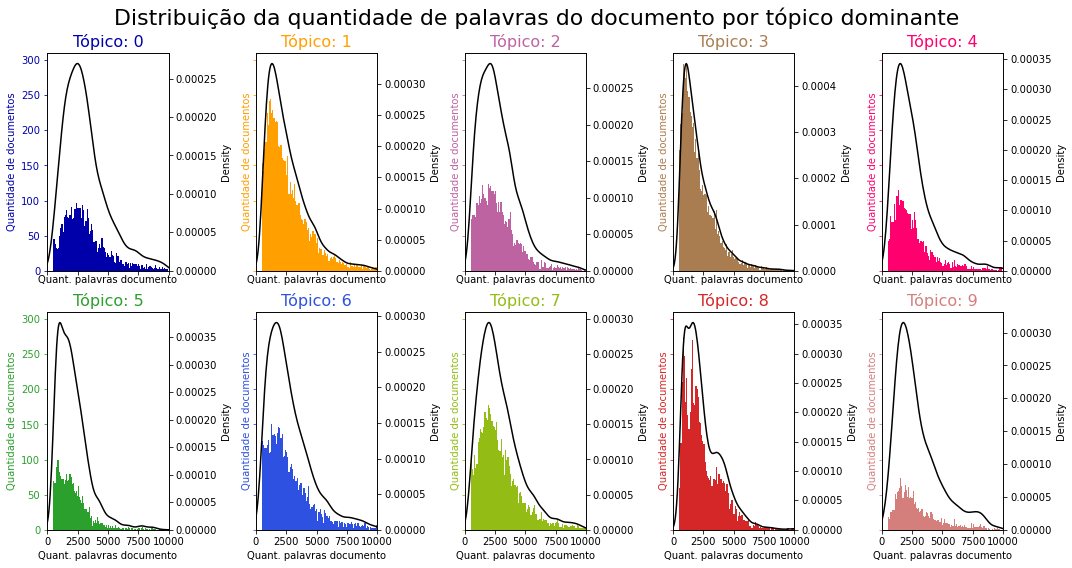

In [71]:
#%matplotlib inline
cols = categorias16

#fig, axes = plt.subplots(3,5,figsize=(16,14), 8, sharex=True, sharey=True)
fig, axes = plt.subplots(2,5,figsize=(15,8),  sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Topico_dominante == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Texto]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 10000), xlabel='Quant. palavras documento')
    ax.set_ylabel('Quantidade de documentos', color=cols[i])
    ax.set_title('Tópico: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,10000,90))
fig.suptitle('Distribuição da quantidade de palavras do documento por tópico dominante', fontsize=22)
plt.show()

## Núvem de palavras das principais palavras-chave de cada tópico

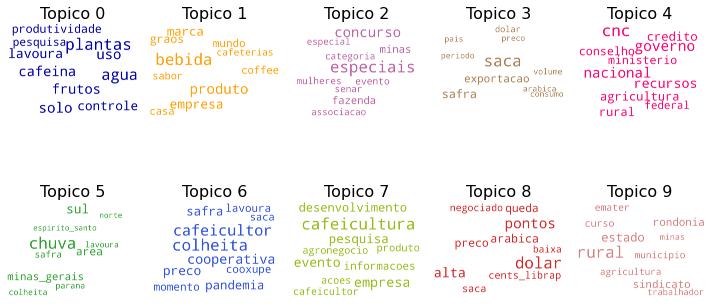

In [79]:
# Aqui temos núvens de palavras das "top n" palavras-chave de cada tópico
# O tamanho proporcional ao peso de cada palavra facitlita a associação das palavras com o significado ou categoriação intuitiva do tópico

#%matplotlib qt
%matplotlib inline

# Nuvem de palavras para N palavras em cada tópico

cols = categorias16

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=10, num_words=10,formatted=False)

fig, axes = plt.subplots(2,5, figsize=(10,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topico ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

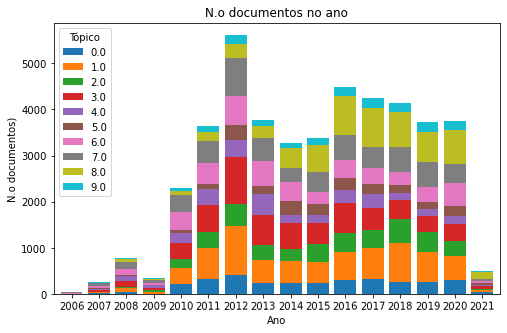

In [80]:
%matplotlib inline
df_trunc1=df_dominant_topic[['Id_documento','Topico_dominante','Ano']]
sub_df1=df_trunc1.groupby(['Ano','Topico_dominante'])['Id_documento'].count()
sub_df1.unstack().plot(kind='bar',stacked=True, ylabel='N.o documentos)', rot=1,figsize=(8,5),title="N.o documentos no ano", width=0.8).legend(ncol=1, title='Tópico')

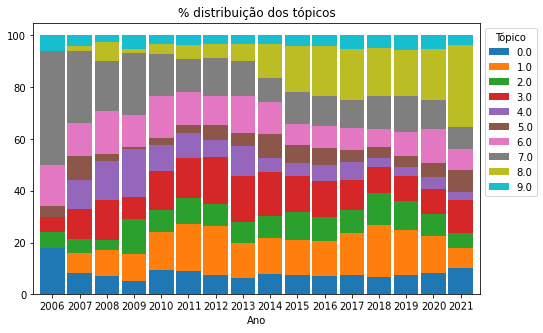

In [81]:
# transposição linhas-colunas
to_plot =sub_df1.unstack()
to_plot_transpose = to_plot.transpose()

# calculo %
to_plot_transpose_pct = to_plot_transpose.div(to_plot_transpose.sum() * .01)

# transposição de retorno a original
to_plot_pct=to_plot_transpose_pct.transpose()

# plotagem
to_plot_pct.plot(kind='bar',stacked=True,rot=1,figsize=(8,5),title="% distribuição dos tópicos",width=0.9).legend(bbox_to_anchor=(1,1), ncol=1, title='Tópico')

In [82]:
# Mostra o tópico dominante para cada documento
# (amostra de 20 docs)

df = df_dominant_topic[['Id_documento', 'Topico_dominante', 'Palavras_chave', 'Ano','Texto']][30200:30220]
df

,Id_documento,Topico_dominante,Palavras_chave,Ano,Texto
30200,30200,6.0,"colheita, cafeicultor, cooperativa, preco, safra, pandemia, momento, lavoura...",2017,bombeiros combatem incendio em secadores de cafe em fazenda em araxa\n o cor...
30201,30201,8.0,"dolar, pontos, alta, arabica, preco, queda, saca, cents_librap, negociado, b...",2017,cafe cota o do arabica caem mais de pts nesta tarde de na bolsa_de_...
30202,30202,4.0,"cnc, governo, nacional, recursos, credito, agricultura, rural, conselho, min...",2017,ccj deve votar suspensao parcial de cobranca do funrural\n depois da sabatin...
30203,30203,1.0,"bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias",2017,suplicy cafes especiais abre superloja na vila olimpia\n nova unidade tem pr...
30204,30204,1.0,"bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias",2017,cafe du centre inaugura nova unidade em foz do iguacu\n nova opcao gastronom...
30205,30205,6.0,"colheita, cafeicultor, cooperativa, preco, safra, pandemia, momento, lavoura...",2017,bombeiros combatem incendio em secadores de cafe em fazenda em araxa\n cerca...
30206,30206,2.0,"especiais, concurso, minas, fazenda, evento, mulheres, categoria, senar, esp...",2017,nota de falecimento luiz sergio de paiva pereira\n nota de falecimento l...
30207,30207,0.0,"plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade,...",2017,incaper pesquisa dinamica da agua da chuva do clima e da umidade do solo em...
30208,30208,4.0,"cnc, governo, nacional, recursos, credito, agricultura, rural, conselho, min...",2017,assul promove reuniao com presenca de deputado estadual em guaxupe\n o deput...
30209,30209,0.0,"plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade,...",2017,ferrugem misteriosa preocupa cafeicultor hondurenhos\n por bureau de intelig...


In [83]:
# Apresenta em formato CSV e persiste em planilha em disco

# Mostra segmento de amostra em formato csv no stdout, para contornar limitações de visualização de textos longos do Pandas
df_dominant_topic[['Topico_dominante', 'Palavras_chave', 'Nome_arquivo', 'Texto']][1000:1010].to_csv(sys.stdout, index=False)

# Gera planilha em disco, do resultado
df_dominant_topic[['Id_documento', 'Topico_dominante', 'Topic_perc_Contrib', 'Palavras_chave', 'Ano', 'Link_doc', 'Texto']].to_csv('data/planilhas/topicos_documentos.csv', index=False)


Topico_dominante,Palavras_chave,Nome_arquivo,Texto
3.0,"saca, safra, exportacao, dolar, volume, arabica, periodo, consumo, pais, preco",rsc_processed_2008_10_29_16h07_id_14441.txt,"producao de graos deve cair no oeste baiano
 ameaca crescente para um novo recorde da producao nacional de graos nesta safra          a combinacao entre custos elevados e escassez de credito ja provocou perdas concretas no oeste da bahia  principal fronteira de soja  milho e algodao no estado 
 levantamento da associacao de agricultores e irrigantes da bahia  aiba  mostra que os produtor da regiao reduziram a area plantada de algodao e milho para apostar na soja  que tem custo de producao mais baixo  mesmo com mais espaco  a produtividade da soja devera cair devido ao menor uso de tecnologia  sobretudo fertilizantes  o que significa que a tendencia e de queda da colheita para as tres culturas 
 apos reuniao entre seu conselho tecnico com representantes da associacao baiana dos produtor de algodao  abapa   ag

KeyError: "['Topic_perc_Contrib'] not in index"

## Amostragem dos documentos que mais representam cada tópico

In [84]:
# Caso se queira ver uma amostragem dos documentos que mais representam cada tópico.

# Efetuando um agrupando de 5 documentos principais ( aqueles que tem a maior porcentagem de contribuição), debaixo de cada tópico
# 

df_doc_topics_sorted= pd.DataFrame()
df_doc_topics_out_grpd = df_topic_docs_keywords.groupby('Topico_dominante')

for i, grp in df_doc_topics_out_grpd:
    df_doc_topics_sorted = pd.concat([df_doc_topics_sorted, grp.sort_values(['Topico_perc_contrib'], ascending=[0]).head(5)], axis=0)

# Reseta o índice do dataframe 
df_doc_topics_sorted.reset_index(drop=True, inplace=True)

# Define os nomes das colunas
df_doc_topics_sorted.columns = ['Topico_dominante', "Topico_perc_contrib", "Palavras_chave", "Ano", "Texto", 'Nome_arquivo', 'Link_doc']
#df_doc_topics_sorted[['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]]

In [85]:
# Mostra a amostragem
df_doc_topics_sorted[['Topico_dominante', "Topico_perc_contrib", "Palavras_chave", "Texto"]]

,Topico_dominante,Topico_perc_contrib,Palavras_chave,Texto
0,0.0,0.9893,"plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade,...",tomar cafe pode prolongar sua vida diz estudo\n para as pessoas que nao con...
1,0.0,0.9889,"plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade,...",tomar tres xicaras de cafe por dia pode aumentar ano de vida\n tomar tres xi...
2,0.0,0.9746,"plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade,...",estudo mostra que o cafe pode ter efeito protetor de sintomas da depressao e...
3,0.0,0.9721,"plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade,...",cafe descafeinado pode fazer bem ao figado\n alguns compostos quimicos da be...
4,0.0,0.9706,"plantas, agua, solo, uso, cafeina, frutos, lavoura, controle, produtividade,...",quatro xicaras de cafe ao dia evitam insuficiencia cardiaca\n segundo estudo...
5,1.0,0.9855,"bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias",espresso martini pronto para beber\n misturar bebida alcoolicas com cafe ja ...
6,1.0,0.9839,"bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias",so ingredientes faca o cafe gelado que bombou na quarentena\n ideal para ...
7,1.0,0.9839,"bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias",octavio cafe lanca dois novos metodos de preparo\n estabelecimento e o unico...
8,1.0,0.9822,"bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias",curiosidades jack daniel s gourmet coffee o whiskafe\n ja ouviu falar de ...
9,1.0,0.9822,"bebida, produto, empresa, marca, graos, mundo, coffee, casa, sabor, cafeterias",crepe de cafe e sugestao de sobremesa \n frutas vermelhas vao complementar o...


In [86]:
df_doc_topics_sorted[['Topico_dominante', "Topico_perc_contrib", "Palavras_chave", 'Ano', "Texto", 'Nome_arquivo', 'Link_doc']].to_csv('data/planilhas/topicos_5_princ_docs.csv', index=False)

## Quantidade de palavras associada aos pesos das palavras-chave dos tópicos

In [87]:
# Quantidades das palavras-chave do tópicos nos documentos
# É interessante observar a frequência com que as palavras aparecem nos documentos.
# A importância (pesos) das palavras-chave é importante.

# É interessante prestar atenção em palavras que ocorrem em vários tópicos 
# e naquelas cuja frequência relativa é maior do que o peso. 
# Essas palavras podem acabar sendo menos importantes. 
# Essas palavras podem ser candidatas à lista de stop words  e dai repetir o processo de treinamento.


from collections import Counter
topics = lda_model.show_topics(num_topics=15, num_words= 15, formatted=False)
data_flat = [w for w_list in data_words_processed for w in w_list]
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

print('Max. importância: ' + str(df['importance'].max()))
print('Max. num. palavras: ' + str(df['word_count'].max()))

Max. importância: 0.055675018578767776
Max. num. palavras: 64039


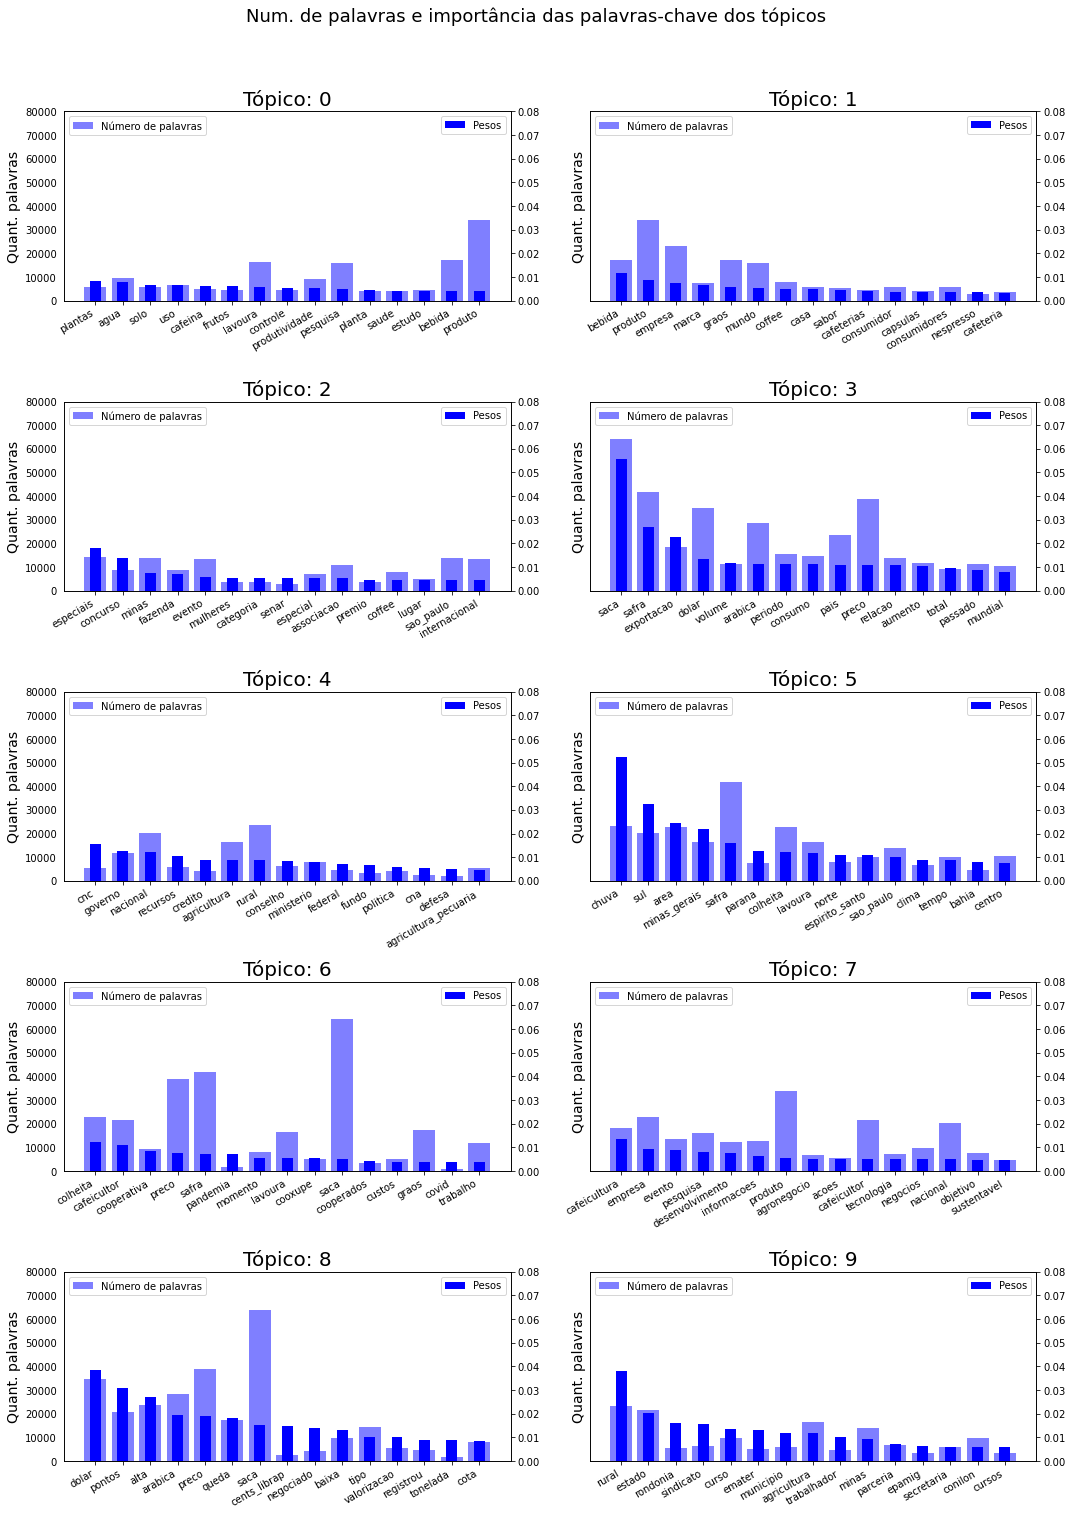

In [88]:
# Plotagem
%matplotlib inline
#%matplotlib qt

#fig, axes = plt.subplots(5,3, figsize=(20,30), sharey=True, dpi=200)
#fig, axes = plt.subplots(2,5, figsize=(30,10), sharey=True, dpi=200)
fig, axes = plt.subplots(5,2, figsize=(15,20), sharey=True)
#cols = categorias16
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color='blue', width=0.8, alpha=0.5, label='Número de palavras')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color='blue', width=0.4, label='Pesos')
    ax.set_ylabel('Quant. palavras', color='black', fontsize=14)
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 80000)
    ax.set_title('Tópico: ' + str(i), color='black', fontsize=20)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right', fontsize=10)
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Num. de palavras e importância das palavras-chave dos tópicos', fontsize=18, y=1.05)    
plt.show()

In [89]:
# Quais são os tópicos mais frequentes nos documentos do fórum?

# Calculando o o número total de documentos atribuídos para cada tópico

def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [90]:
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, start=0, end=-1) 

In [91]:
# Distribuição dos tópicos dominantes de cada documento

df = pd.DataFrame(dominant_topics, columns=['Id_documento', 'Topico_dominante'])
dominant_topic_in_each_doc = df.groupby('Topico_dominante').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()


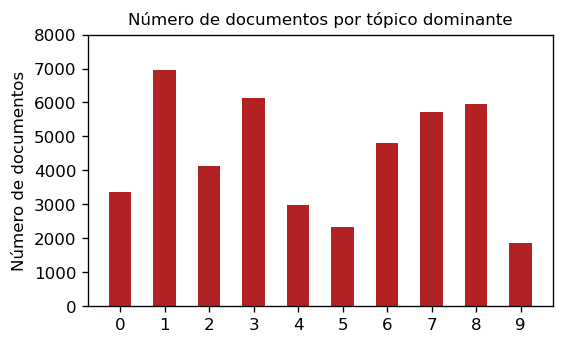

In [92]:
# Plot
fig, ax1 = plt.subplots(1, figsize=(5, 3),  dpi=120,sharey=True)

# Distribuição de documentos em função de seus tópicos dominantes
ax1.bar(x='Topico_dominante', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Topico_dominante.unique().__len__()))
ax1.set_title('Número de documentos por tópico dominante', fontdict=dict(size=10))
ax1.set_ylabel('Número de documentos')
ax1.set_ylim(0, 8000)

plt.show()

## Fim